In [1]:
%load_ext autoreload
%autoreload 2

# ResNet

[ResNet](https://arxiv.org/abs/1512.03385) won the Imagenet competition in 2015 and it introduced some key concepts that are still used today. The main contribution is to use a series of residual blocks instead of a plain stack of convolutional layers to help with the training process, and popularized the use of batch norm. 

![resnet](pics/resnet.png)

In [2]:
import torch
import torch.nn as nn
from torch.nn import Sequential as S 
from torch.nn import Conv2d as C
from torch.nn import ReLU as R 
from torch.nn import MaxPool2d as M
from torch.nn import BatchNorm2d as BN
from torch.nn import Identity as I
from torch.nn import AdaptiveAvgPool2d as Ap
from torch.nn import Flatten as F
from torch.nn import Linear as L


resenet18config = {
    'l': [
		{'r': 2, 'f': 64},
		{'r': 2, 'f': 128},
		{'r': 2, 'f': 256},
		{'r': 2, 'f': 512}
    ], 
    'b': False
}


class ResBlock(nn.Module):
    def __init__(self, f1, f2, l0, b0):
        # f1 -> input filters, f2 -> output filters, l0 -> is first layer?, b0 -> is first block in layer?
        super(ResBlock, self).__init__()
        cb = lambda f1,f2,s=1: S(C(f1,f2,3,s,1),R(),BN(f2)) 
        self.block = S(cb(f1,f2,2 if b0 and not l0 else 1),cb(f2,f2)) # stride 2 to reduce dims in first block of each layer
        self.shortcut = C(f1,f2,1,2,0) if b0 and not l0 else I() # apply 1x1 conv to input if needed to match dimensions in residual connection
    def forward(self, x):
        return self.shortcut(x) + self.block(x)
    

class ResBottlBlock(nn.Module):
    def __init__(self, f1, f2, l0, b0):
        super(ResBottlBlock, self).__init__()
        cb = lambda f1,f2,k=3,s=1: S(C(f1,f2,k,s,1 if k == 3 else 0),R(),BN(f2)) 
        self.block = S(cb(f1*4 if not b0 else f1,f2,1,2 if b0 and not l0 else 1),cb(f2,f2),cb(f2,f2*4,1))
        self.shortcut = C(f1,f2*4,1,2 if b0 and not l0 else 1,0) if b0 else I()
    def forward(self, x):
        return self.shortcut(x) + self.block(x)

class ResNet(nn.Module):
    def __init__(self, conf):
        super(ResNet, self).__init__()
        self.backbone = S(
            C(3, conf['l'][0]['f'], 7, 2, 3),BN(conf['l'][0]['f']),R(),M(3, 2, 1), # first layer
            *[S(*[
                ResBottlBlock(conf['l'][i-1]['f']*4 if i > 0 and j == 0 else l['f'], l['f'], i == 0, j == 0) if conf['b'] else ResBlock(conf['l'][i-1]['f'] if i > 0 and j == 0 else l['f'], l['f'], i == 0, j == 0)
                for j in range(l['r'])]) 
            for i, l in enumerate(conf['l'])]
        )
        self.head = S(Ap((1, 1)),F(),L(conf['l'][-1]['f']*4 if conf['b'] else conf['l'][-1]['f'], 1000))
    def forward(self, x):
        return self.head(self.backbone(x))
    

In [3]:
x = torch.randn(1, 3, 256, 256)
model = ResNet(resenet18config)
model(x).shape

torch.Size([1, 1000])

These are the hyperparameters used in the original paper:

In [5]:
from convnets.datasets import ImageNet
import albumentations as A
from convnets.train import seed_everything
from torch.utils.data import DataLoader
from convnets.train import fit 
from convnets.metrics import error, top5_error
from convnets.models import ResNet, ResNetConfig
import lightning 

seed_everything()

train_trans = A.Compose([
    A.SmallestMaxSize(list(range(256, 481))), # sacale augmentation
    A.RandomCrop(224, 224),
    A.HorizontalFlip(),
    A.RGBShift()
])

val_trans = A.Compose([
    A.SmallestMaxSize(224),
    A.CenterCrop(224, 224)
])

path = '/fastdata/imagenet' 
dataloaders  =  {
    'train': DataLoader(ImageNet(path, 'train', train_trans), batch_size=256, shuffle=True, num_workers=10, pin_memory=True),
    'val': DataLoader(ImageNet(path, 'val', val_trans), batch_size=256, shuffle=False, num_workers=10, pin_memory=True),
}

model = ResNet(ResNetConfig.r18)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.1, verbose=True, threshold_mode='abs', min_lr=1e-4)
criterion = nn.CrossEntropyLoss()
metrics = {'t1err': error, 't5err': top5_error}

class Callback:
    def after_val(self, val_logs):
        scheduler.step(val_logs['t1err'][-1])

fabric = lightning.Fabric(accelerator="gpu", devices=1, precision='bf16-mixed', callbacks=[Callback()])
hist = fit(
    model, 
    dataloaders, 
    optimizer, 
    criterion,
    metrics, 
    max_epochs=10, # original paper says 120 epochs approx. (60 x 10^4 its)
    fabric=fabric,
    limit_train_batches=100, # comment to train on full dataset
    limit_val_batches=100 # comment to validate on full dataset
)


/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision 

Number of trainable parameters: 11692520
Compiling model ...


Epoch 00003: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00006: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.


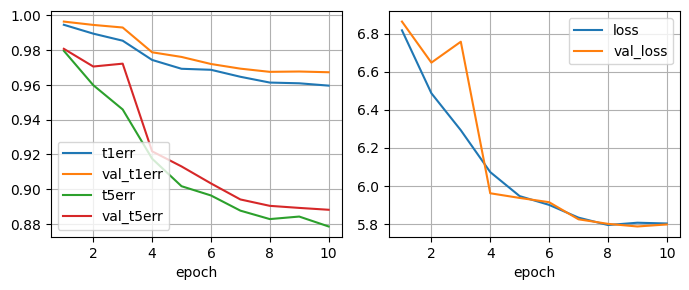

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['t1err', 'val_t1err', 't5err', 'val_t5err'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()


For testing, the authors used tta with 5 crops + hflips at different scales: 224, 256, 384, 480, 640

In [7]:
from tqdm import tqdm

# tta evaluation
model.cuda()
model.eval()
metrics = {}
limit_val_batches = 100 
for s in [224, 256, 384, 480, 640]:
	print(f'evaluating at scale {s}...')
	trans = A.Compose([
		A.SmallestMaxSize(s),
		A.CenterCrop(s, s)
	])
	dataloader = DataLoader(ImageNet(path, 'val', trans), batch_size=8, shuffle=False, num_workers=10, pin_memory=True)
	metrics[s] = {'t1err': [], 't5err': []}
	with torch.no_grad():
		for ix, batch in enumerate(tqdm(dataloader)):
			x, y = batch
			x, y = x.cuda(), y.cuda()
			y_hat = model.tta(x, s)
			err = error(y_hat, y)
			metrics[s]['t1err'].append(err.item())
			top5err = top5_error(y_hat, y)
			metrics[s]['t5err'].append(top5err.item())
			if ix > limit_val_batches:
				break

evaluating at scale 224...


  0%|                                                                                                                            | 0/6250 [00:00<?, ?it/s]


AttributeError: 'ResNet' object has no attribute 'tta'

In [ ]:
import numpy as np

_metrics = pd.DataFrame({s: {n: np.mean(v) for n, v in m.items()} for s, m in metrics.items()})
_metrics

In [ ]:
_metrics.mean(1)

The final submission that won ImageNet was an ensamble of 5 different ResNets.